In [28]:
#load supplimentary packages
import os
import matplotlib.pyplot as plt
from copy import deepcopy

current_directory = os.getcwd()

In [29]:
#load cuurent experiment packages
from utils.utils import *
from utils.data_generation import *
from utils.constructors import *
from mgym.algorithms import *

In [30]:
#Setup factories
EnvFactory.constructors['DistillationColumn'] = create_env_DistillationColumn
ControlFactory.constructors['DistillationColumn'] = create_pid_conrol_DistillationColumn

# ================ OFFLINE RL RESULTS==========================

In [40]:
def DistillationColumn_show_data(algs_data):
    fig = plt.figure(figsize=(12,3))
    plt.subplot(1, 2, 1)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["rrs"], label=alg_name)
    plt.ylim(2,3)
    
    plt.subplot(1, 2, 2)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["xds"])
    plt.ylim(0.75,0.85)
    
    plt.gca().legend([_ for _ in algs_data], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [34]:
#show target metricses
#Here we show metrics only for temperature (T) as the most indicative parameter.
def DistillationColumn_metrics(metrics_calculators):
    for alg_name in metrics_calculators:
        _mc = metrics_calculators[alg_name]
        print(f"{alg_name}: ISF={_mc.ISF()[0]}; IAE={_mc.IAE()[0]}; ITAE={_mc.ITAE()[0]}; ITSH{_mc.ITSH()[0]};")

In [35]:
#run pretrained models on target scenario
def DistillationColumn_assess_offline(config, algs):
    config['normalize'] = False
    config['compute_diffs_on_reward'] = False
    
    control = ControlFactory.create(config=config)
    env_name = config["process_name"]
    location = "offline"
    logdir = os.path.join(os.path.join(os.path.join(".","pretrained"), f"{env_name}"),f"{location}")

    algorithms = []
    algorithms.append( (control, 'baseline', config['normalize'], ) )
    for alg_name in algs :
        algorithms.append( (RLModel(alg_name, logdir), alg_name, config['normalize'], ) )

    init_state = np.array([],dtype=np.float32)
    setpoints  = np.array([0.80,],dtype=np.float32)
        
    processes_data = {}
    metrics_calculators = {}
    for alg, alg_name, normalize in algorithms:
        _state = deepcopy(init_state)
        _env = EnvFactory.create(config=config)
        _env.reset(initial_state = init_state)
    
        processes_data[alg_name] = None
        metrics_calculators[alg_name] = MetricsCalculator(setpoints=setpoints, dt = 1)
        _mc = metrics_calculators[alg_name]

        iterations = 100    
        _state, _reward, _done, _info = _env.step(action=_env.normalize_actions([3,]))
        _process_data = {"rrs":[], "xds":[], }
        for _ in range(iterations):
            _u = alg.predict(_state)
            _process_data["xds"].append(_state[0])
            _process_data["rrs"].append(_u[0])
            _mc.update(_state)

            _observation, _reward, _done, _info = _env.step(_u)
            _state = _observation
            
            processes_data[alg_name] = _process_data

    return processes_data, metrics_calculators

In [36]:
config = load_config_yaml(current_directory, 'DistillationColumn')

In [37]:
processes_data, metrics_calculators = DistillationColumn_assess_offline(config=config, algs=[ 'COMBO'
                                                                          , 'MOPO'
                                                                          ,  'BC'
                                                                          , 'CQL'
                                                                          , 'PLAS'
                                                                          , 'PLASWithPerturbation'
                                                                          , 'BEAR'
                                                                          , 'SAC'
                                                                          , 'BCQ'
                                                                          , 'CRR'
                                                                          , 'AWAC'
                                                                          , 'DDPG'
                                                                          , 'TD3'
                                                           ])

2025-10-15 19:44:40 [warning  ] Unused arguments are passed.   algorithm=COMBO
2025-10-15 19:44:40 [warning  ] Unused arguments are passed.   algorithm=MOPO
2025-10-15 19:44:40 [warning  ] Unused arguments are passed.   algorithm=BC gamma=1.0 generated_maxlen=100000 n_steps=1 real_ratio=1.0 reward_scaler=None
2025-10-15 19:44:40 [warning  ] Unused arguments are passed.   algorithm=CQL generated_maxlen=100000 real_ratio=1.0
2025-10-15 19:44:40 [warning  ] Unused arguments are passed.   algorithm=PLAS generated_maxlen=100000 real_ratio=1.0
2025-10-15 19:44:40 [warning  ] Unused arguments are passed.   algorithm=PLASWithPerturbation generated_maxlen=100000 real_ratio=1.0
2025-10-15 19:44:40 [warning  ] Unused arguments are passed.   algorithm=BEAR generated_maxlen=100000 real_ratio=1.0
2025-10-15 19:44:40 [warning  ] Unused arguments are passed.   algorithm=SAC generated_maxlen=100000 real_ratio=1.0
2025-10-15 19:44:40 [warning  ] Unused arguments are passed.   algorithm=BCQ generated_max

In [38]:
DistillationColumn_metrics(metrics_calculators)

baseline: ISF=0.005815765883606827; IAE=0.36482487439961336; ITAE=11.959626344361148; ITSH0.10345346990262028;
COMBO: ISF=0.0030226761637819973; IAE=0.28923841195321826; ITAE=13.914935871640633; ITSH0.12403598404000092;
MOPO: ISF=0.007755218316680723; IAE=0.5213176471704877; ITAE=22.679900264540926; ITSH0.293400307747718;
BC: ISF=0.006031652859717418; IAE=0.45411120886286266; ITAE=21.965436360011914; ITSH0.28170277396619886;
CQL: ISF=0.011423235125584519; IAE=0.5119912723664007; ITAE=18.46460975825435; ITSH0.29502865717383625;
PLAS: ISF=0.0052443213804669155; IAE=0.4575819363203686; ITAE=23.40519503127876; ITSH0.2571077751838269;
PLASWithPerturbation: ISF=0.0040921717224053755; IAE=0.37793193969740085; ITAE=16.353492108547037; ITSH0.1536802118019215;
BEAR: ISF=0.009644437679799295; IAE=0.6034085714045718; ITAE=25.406412465269216; ITSH0.35575098535919325;
SAC: ISF=0.5958561967767357; IAE=5.37326992419824; ITAE=271.9395175019219; ITSH29.474612392240452;
BCQ: ISF=0.005129966925567373; IAE

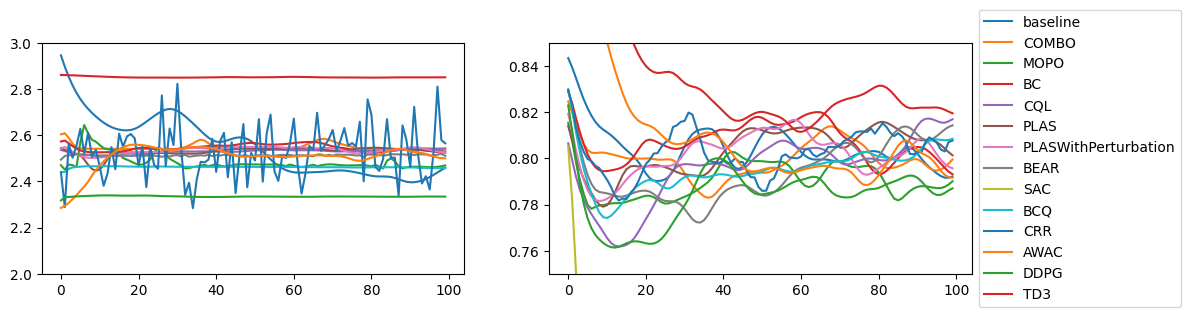

In [41]:
DistillationColumn_show_data(processes_data)

In [15]:
#show only graphics with best performance

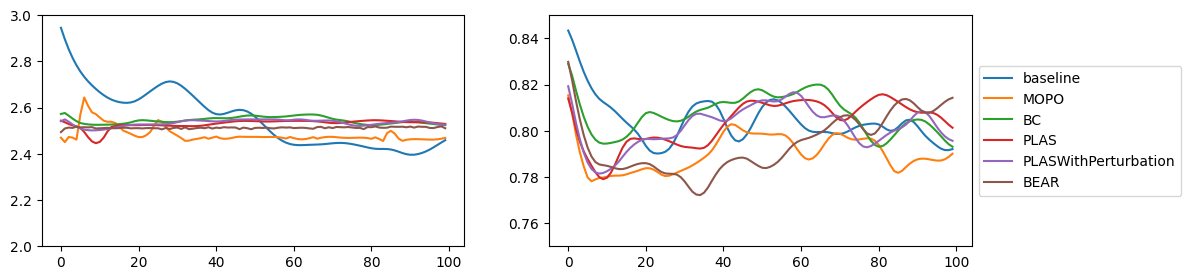

In [43]:
best_data = {}
for alg in ['baseline', 'MOPO', 'BC', 'PLAS', 'PLASWithPerturbation', 'BEAR',]:
    best_data[alg] = processes_data[alg]
DistillationColumn_show_data(best_data)

# ================ ONLINE RL RESULTS==========================

In [44]:
import ray as ray 
from ray import tune
from ray.tune.registry import register_env
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLogger

In [45]:
AlgorithmsFactory.constructors["ppo"] = setup_alg_ppo
AlgorithmsFactory.constructors["ars"] = setup_alg_ars
AlgorithmsFactory.constructors["a3c"] = setup_alg_a3c
AlgorithmsFactory.constructors["sac"] = setup_alg_sac
AlgorithmsFactory.constructors["impala"] = setup_alg_impala
AlgorithmsFactory.constructors["a2c"] = setup_alg_a2c

In [46]:
env_name = 'DistillationColumn'
config['normalize'] = True
config['compute_diffs_on_reward'] = False
logdir = os.path.join(os.path.join(os.path.join(current_directory,"pretrained"), f"{env_name}"),f"online")

In [47]:
def DistillationColumn_case(algorithms, config):
    init_state = np.array([],dtype=np.float32)
    setpoints  = np.array([0.80,],dtype=np.float32)
        
    processes_data = {}
    metrics_calculators = {}
    for alg, alg_name in algorithms:
        _state = deepcopy(init_state)
        _env = EnvFactory.create(config=config)
        _env.reset(initial_state = init_state)
    
        processes_data[alg_name] = None
        metrics_calculators[alg_name] = MetricsCalculator(setpoints=setpoints, dt = 1)
        _mc = metrics_calculators[alg_name]

        iterations = 100    
        _state, _reward, _done, _info = _env.step(action=_env.normalize_actions([3,]))
        _process_data = {"rrs":[], "xds":[], }
        for _ in range(iterations):
            _u = alg.predict(_state)
            dn_u = _env.denormalize_actions(_u)
            dn_s = _env.denormalize_observations(_state)
            _mc.update(dn_s)

            _process_data["xds"].append(dn_s[0])
            _process_data["rrs"].append(dn_u[0])               
            processes_data[alg_name] = _process_data

            _observation, _reward, _done, _info = _env.step(_u)
            _state = _observation

    return processes_data, metrics_calculators

In [48]:
def DistillationColumn_assess_online(config, algs):
    processes_data = {}
    metrics_calculators = {}
    for alg_name in algs:
        try:
            rl_trainer, rl_config = AlgorithmsFactory.create(alg_name=alg_name,config = config)
            env_config = {
                "env_name": env_name,
                "normalize": config['normalize'],
                "dense_reward": config['dense_reward'],
                "compute_diffs_on_reward": config['compute_diffs_on_reward'],    
            }
            
            def env_creator(env_config):
                return create_env_DistillationColumn(config)
                
            register_env("DistillationColumn", env_creator)
             
            checkpoint_path = os.path.join(logdir,alg_name)
            checkpoint_path = os.path.join(checkpoint_path,'best')
            checkpoint_path = os.path.join(checkpoint_path,'best') 
            
            rl_config["env_config"] = env_config
            rl_config["framework"] = "torch"
            rl_config["evaluation_interval"] = int(config['train_iter'] / 10)
            agent = rl_trainer(rl_config, env=config['process_name'])
            agent.restore(checkpoint_path)
        
            algorithms=[]
            algorithms.append((RayAgentWrapper(agent=agent),alg_name,))
        
            _process_data, _metrics_calculators = DistillationColumn_case(algorithms=algorithms, config=config)
        
            processes_data[alg_name] = _process_data[alg_name]
            metrics_calculators[alg_name] = _metrics_calculators[alg_name]
                
        except Exception as exception:
            print(f'{alg_name} exception: {exception}')

    return processes_data, metrics_calculators

In [ ]:
processes_data, metrics_calculators = DistillationColumn_assess_online(config = config, algs = [ 'ppo'
                                                          , 'sac'
                                                          , 'ars'
                                                          , 'impala'
                                                          , 'a2c'
                                                          ])

In [51]:
DistillationColumn_metrics(metrics_calculators)

ppo: ISF=0.0020194594506364317; IAE=0.2482995125577342; ITAE=13.875162858321426; ITSH0.09584918675383187;
sac: ISF=0.119213045694052; IAE=1.6276182761476552; ITAE=48.37186379689534; ITSH2.8124851988072597;
ars: ISF=0.00015765794621585923; IAE=0.07549993205639022; ITAE=3.8051800062252426; ITSH0.006581148220889865;
impala: ISF=0.0034175664649668024; IAE=0.31188210751759865; ITAE=13.409263051583237; ITSH0.11611390258985207;
a2c: ISF=0.006425635562953228; IAE=0.4851804156054196; ITAE=25.233977777493436; ITSH0.313797434395632;


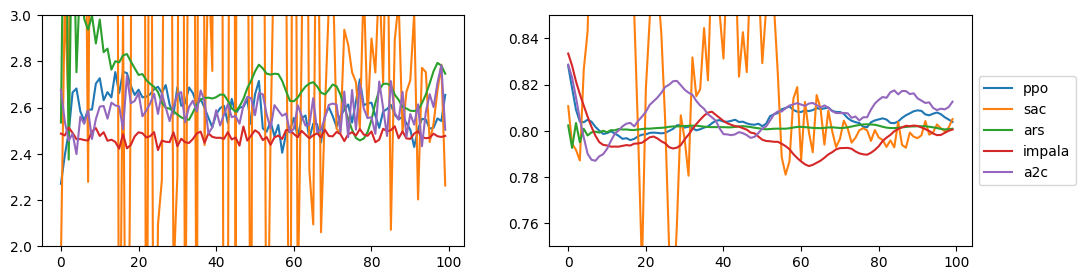

In [52]:
DistillationColumn_show_data(processes_data)